<a href="https://colab.research.google.com/github/Mohammad-H-Zahrawi/machine_Learning_fundamentals/blob/master/deep_learning/5_Transfer_Learning_with_TensorFlow_Part_1_Feature_Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Transfer Learning with TensorFlow Part 1: Feature Extraction

In [ ]:
# Are we using a GPU?
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



### importing data

In [ ]:
#get data
import zipfile

#download data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2021-12-02 06:54:30--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.143.128, 173.194.69.128, 173.194.79.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.143.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  51.2MB/s    in 3.1s    

2021-12-02 06:54:34 (51.2 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/tes

Notice how each of the training directories now has 75 images rather than 750 images. This is key to demonstrating how well transfer learning can perform with less labelled images.

The test directories still have the same amount of images. This means we'll be training on less data but evaluating our models on the same amount of test data.

### Creating data loaders (preparing the data)

Now we've downloaded the data, let's use the [`ImageDataGenerator`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) class along with the `flow_from_directory` method to load in our images.

In [ ]:
cd /content

/content


In [ ]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224,224)
BATCH_SIZE=32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen=ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

print("Testing images:")
test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


Excellent! Loading in the data we can see we've got 750 images in the training dataset belonging to 10 classes (75 per class) and 2500 images in the test set belonging to 10 classes (250 per class).

### Setting up callbacks (things to run whilst our model trains)

Before we build a model, there's an important concept we're going to get familiar with because it's going to play a key role in our future model building experiments.

And that concept is **callbacks**.

[Callbacks](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks) are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks include:
* [**Experiment tracking with TensorBoard**](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard) - log the performance of multiple models and then view and compare these models in a visual way on [TensorBoard](https://www.tensorflow.org/tensorboard) (a dashboard for inspecting neural network parameters). Helpful to compare the results of different models on your data.
* [**Model checkpointing**](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) - save your model as it trains so you can stop training if needed and come back to continue off where you left. Helpful if training takes a long time and can't be done in one sitting.
* [**Early stopping**](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) - leave your model training for an arbitrary amount of time and have it stop training automatically when it ceases to improve. Helpful when you've got a large dataset and don't know how long training will take.

In [ ]:
# Create tensorboard callback (functionized because need to create a new one for each model)
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

Because you're likely to run multiple experiments, it's a good idea to be able to track them in some way.

In our case, our function saves a model's performance logs to a directory named `[dir_name]/[experiment_name]/[current_timestamp]`, where:
* `dir_name` is the overall logs directory
* `experiment_name` is the particular experiment
* `current_timestamp` is the time the experiment started based on Python's [`datetime.datetime().now()`](https://docs.python.org/3/library/datetime.html#datetime.datetime.now)

### Creating models using TensorFlow Hub

Now we're going to do a similar process, except the majroity of our model's layers are going to come from TensorFlow Hub.

We can access pretrained models on: https://tfhub.dev/

Browsing the TensorFlow Hub page and sorting for image classification, we found the following feature vector model link: https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

In [ ]:
efficient_url_hub = 'https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1'

resnet_url_hub= 'https://tfhub.dev/google/imagenet/resnet_v1_50/classification/5'

efficient_url_class = 'https://tfhub.dev/tensorflow/efficientnet/b0/classification/1'


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers  

In [ ]:
print(IMAGE_SHAPE)
print(IMAGE_SHAPE+(3,))

(224, 224)
(224, 224, 3)


In [ ]:
# Let's make a create_model() function to create a model from a URL

def create_model(model_url, num_classes=10):
  """  
  Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in the output layer,
      should be equal to number of target classes, default 10.
  
  Returns:
    An uncompiled Keras Sequential model with model_url as feature extractor
    layer and Dense output layer with num_classes output neurons.
  """
  feature_extractor_layer=hub.KerasLayer(model_url, trainable=False,# freeze the already learned patterns
                                         name='feature_extractor_layer',
                                         input_shape=IMAGE_SHAPE+(3,))
  
  #create our own model
  model=tf.keras.Sequential([
                             feature_extractor_layer,
                             layers.Dense(num_classes, activation='softmax',name='output_layer')
                            
  ])

  return model

###  Creating and testing ResNet TensorFlow Hub Feature Extraction model

In [ ]:
# create resnet50 model

resnet_model = create_model(resnet_url_hub,
                            num_classes=train_data_10_percent.num_classes)

In [ ]:
# compile our resnet model
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'] 
                     )

In [ ]:
# Let's fit our ResNet model to the data (10 percent of 10 classes)
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback(dir_name='tensorflow_hub',
                                                                         experiment_name='resnet50V2')])

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20211202-075915
Epoch 1/5
24/24 [==============================] - 439s 19s/step - loss: 1.9095 - accuracy: 0.3707 - val_loss: 1.2810 - val_accuracy: 0.5816
Epoch 2/5
24/24 [==============================] - 483s 21s/step - loss: 0.8981 - accuracy: 0.7400 - val_loss: 0.8732 - val_accuracy: 0.7188
Epoch 3/5
24/24 [==============================] - 434s 19s/step - loss: 0.6121 - accuracy: 0.8227 - val_loss: 0.7896 - val_accuracy: 0.7384
Epoch 4/5
24/24 [==============================] - 482s 21s/step - loss: 0.4664 - accuracy: 0.8880 - val_loss: 0.7147 - val_accuracy: 0.7696
Epoch 5/5
24/24 [==============================] - 483s 21s/step - loss: 0.3744 - accuracy: 0.9107 - val_loss: 0.6975 - val_accuracy: 0.7752


Wow!

That. Is. Incredible. Our transfer learning feature extractor model out performed ALL of the previous models we built by hand... (substantially) and in a quicker training time AND with only 10% of the training examples.

In [ ]:
# Let's create a function to plot our loss curves...
# Tidbit: you could put a function like this into a script called "helper.py" and import it when you need it...
import matplotlib.pyplot as plt

# Plot the validation and training curves
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow History object.

  Returns:
    Plots of training/validation loss and accuracy metrics.
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  # Plot loss
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();


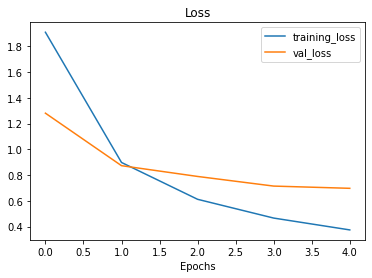

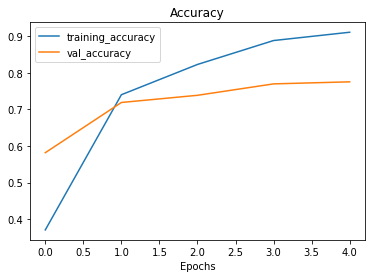

In [ ]:
plot_loss_curves(resnet_history)

### Creating and testing EfficientNetB0 TensorFlow Hub Feature Extraction model

Create EfficinetNetB0 feature extractor model - details on EfficientNet: https://ai.googleblog.com/2019/05/efficientnet-improving-accuracy-and.html#:~:text=EfficientNet%2DB0%20is%20the%20baseline,than%20the%20best%20existing%20CNN.

In [ ]:
# creat efficientNet model
efficientnet_model = create_model(model_url=efficient_url_hub,
                                  num_classes=train_data_10_percent.num_classes)

#compile efficientNet model
efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

# Fit EfficientNet model to 10% of training data
efficientnet_history = efficientnet_model.fit(train_data_10_percent, 
                                              epochs=5, 
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name='tensorfloww_hub',
                                                         experiment_name='efficientnetb0')])


Saving TensorBoard log files to: tensorfloww_hub/efficientnetb0/20211202-091426
Epoch 1/5
24/24 [==============================] - 177s 7s/step - loss: 1.8125 - accuracy: 0.4360 - val_loss: 1.2869 - val_accuracy: 0.7024
Epoch 2/5
24/24 [==============================] - 179s 8s/step - loss: 1.0564 - accuracy: 0.7760 - val_loss: 0.8597 - val_accuracy: 0.8168
Epoch 3/5
24/24 [==============================] - 180s 8s/step - loss: 0.7532 - accuracy: 0.8253 - val_loss: 0.6941 - val_accuracy: 0.8420
Epoch 4/5
24/24 [==============================] - 180s 8s/step - loss: 0.6071 - accuracy: 0.8640 - val_loss: 0.6097 - val_accuracy: 0.8572
Epoch 5/5
24/24 [==============================] - 164s 7s/step - loss: 0.5124 - accuracy: 0.8933 - val_loss: 0.5513 - val_accuracy: 0.8656


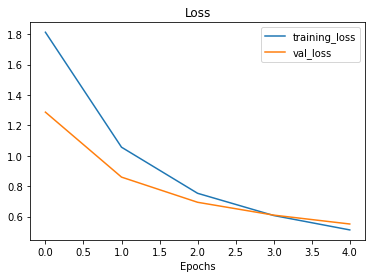

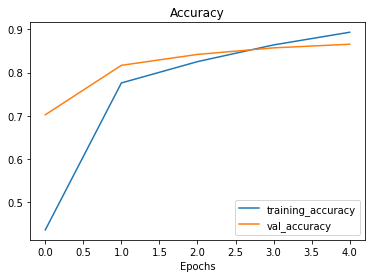

In [ ]:
plot_loss_curves(efficientnet_history)

In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_layer (Ke  (None, 2048)             23564800  
 rasLayer)                                                       
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
efficientnet_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_layer (Ke  (None, 1280)             4049564   
 rasLayer)                                                       
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


##### Creating and testing efficientnet/b0/classification TensorFlow Hub Feature Extraction model

In [ ]:
# creat efficientNet model
efficientnet_model_class = create_model(model_url=efficient_url_class,
                                  num_classes=train_data_10_percent.num_classes)

#compile efficientNet model
efficientnet_model_class.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

# Fit EfficientNet model to 10% of training data
efficientnet_history_class = efficientnet_model_class.fit(train_data_10_percent, 
                                              epochs=5, 
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name='tensorfloww_hub',
                                                         experiment_name='efficientnetb0')])

Saving TensorBoard log files to: tensorfloww_hub/efficientnetb0/20211202-094045
Epoch 1/5
24/24 [==============================] - 174s 7s/step - loss: 2.2836 - accuracy: 0.2413 - val_loss: 2.2737 - val_accuracy: 0.4016
Epoch 2/5
24/24 [==============================] - 179s 8s/step - loss: 2.2684 - accuracy: 0.4453 - val_loss: 2.2588 - val_accuracy: 0.5020
Epoch 3/5
24/24 [==============================] - 180s 8s/step - loss: 2.2541 - accuracy: 0.5000 - val_loss: 2.2439 - val_accuracy: 0.5336
Epoch 4/5
24/24 [==============================] - 180s 8s/step - loss: 2.2396 - accuracy: 0.5520 - val_loss: 2.2292 - val_accuracy: 0.5664
Epoch 5/5
24/24 [==============================] - 164s 7s/step - loss: 2.2255 - accuracy: 0.5720 - val_loss: 2.2146 - val_accuracy: 0.5832


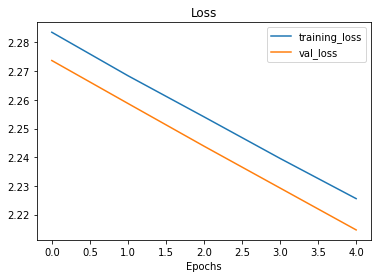

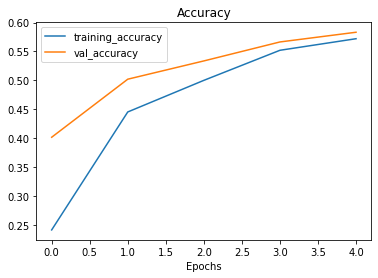

In [ ]:
plot_loss_curves(efficientnet_history_class)

In [ ]:
efficientnet_model_class.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_layer (Ke  (None, 1000)             5330564   
 rasLayer)                                                       
                                                                 
 output_layer (Dense)        (None, 10)                10010     
                                                                 
Total params: 5,340,574
Trainable params: 10,010
Non-trainable params: 5,330,564
_________________________________________________________________


### Different types of transfer learning

* **"As is" transfer learning** - using an existing model with no changes what so ever (e.g using ImageNet model on 1000 ImageNet classes, none of your own)
* **"Feature extraction"** transfer learning - use the prelearned patterns of an existing model (e.g. EfficientNetB0 trained on ImageNet) and adjust the output layer for your own problem (e.g. 1000 classes -> 10 classes of food)
* **"Fine-tuning" transfer learning** - use the prelearned patterns of an existing model and "fine-tune" many or all of the underlying layers (including new output layers)

### Comparing our models results using TensorBoard

> 🔑 **Note:** When you upload things to [TensorBoard.dev](https://tensorboard.dev/), you experiments are public. So if you're running private experiments (things you don't want others to see) do not upload them to TensorBoard.dev.

In [ ]:
# Upload TensorBoard dev records

!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2"\
  --description "Comparing two different TF Hub feature extraction model architectures using 10% of the training data"\
  --one_shot

2021-12-02 11:49:57.779204: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%

Our TensorBoard experiments are uploaded publically here: https://tensorboard.dev/experiment/dQBrpdwIRgS2qI0Andv8Yg/

In [ ]:
# Delete an experiment
# !tensorboard dev delete --experiment_id dQBrpdwIRgS2qI0Andv8Yg

In [ ]:
# Confirm the deletion by re-checking what experiments you have left
!tensorboard dev list

2021-12-02 11:52:49.637602: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
No experiments. Use `tensorboard dev upload` to get started.
